# **0. TO DO**

### **Mandatory :** 
* Recheck the comments to use corect terminology according to the literarture (Ernest)
* Develop further the statistical description of the first EDA part.
* Notebooks :
    * Ernest - OK
    * Sofiane - OK
    * Malak - en cours
    * Annabelle - en cours
    * Marco - en cours


### **Optional :**
* Move custom functions to a separate file
* Try to turn turn the Phase 5 into pipelines with imblearn.pipeline

---
# **1. LIBRARIES & DATA IMPORT**
---

In [198]:
# Main libraries imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Scipy imports
from scipy.stats.mstats import winsorize

# Sklearn imports
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [195]:
# Original df import
original_df = pd.read_csv(r"../Data/TAIPEI_diabetes.csv")

# Creation of a deep copy of the original df
original_raw_df = original_df.copy()

### **Custom functions**

In [193]:
# A function that allows to check if the data points data types corresponds to their columns' data type
def dtype_per_column(df):
    for col in df.columns:
        print(f"{col}:")
        dtype_count = {}

        for i in df[col]:
            dtype_name = type(i).__name__
            if dtype_name in dtype_count:
                dtype_count[dtype_name] = dtype_count[dtype_name] + 1
            else:
                dtype_count[dtype_name] = 1

        for dtype_name in dtype_count:
            print(f"{dtype_name}: {str(dtype_count[dtype_name])}")
            print("\n")

# A function that allows to generate and compare descriptive statistics for a specific column across multiple dataframes
def compare_statistics_per_col(dataframes, dataframes_names, column):
    descriptive_statistics = []
    
    for df in dataframes:
        statistics = df[column].describe()
        descriptive_statistics.append(statistics)
    
    result = pd.concat(descriptive_statistics, axis = 1, keys = dataframes_names)

    print("---" * 10)
    print(f"Comparison of descriptive statistics for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    return result

# A function that allows to generate and compare histograms for a specific column across multiple dataframes
def compare_histograms_per_col(dataframes, dataframes_names, column):

    n = len(dataframes)
    fig, axes = plt.subplots(ncols = n, nrows = 1, figsize = (5 * n, 4))
    
    for i in range(n):
        ax = axes[i]
        df = dataframes[i]
        name = dataframes_names[i]
        sns.histplot(data = df, x = column, ax = ax, multiple = "stack", kde = True)
        ax.set_title(f"{name}")
    
    print("---" * 10)
    print(f"Comparison of data distributions for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    
    plt.tight_layout()
    plt.show()


# A function that allows to check of the top 10 most frequent values per column in a dataframe
def top_10_frequent_values(df):
    for col in df:
        print(f"Top 10 most frequent values for \x1B[4m{col}\x1B[0m::")
        print(df[col].value_counts().head(10))
        print("\n")

# A function that allow to check of duplicated data points per column
def duplicate_values_per_column(df):
    duplicated_values = df[col].duplicated().sum()
    for col in df.columns:
        print(f"{col}: {duplicated_values}")

# A function that generates heat map from two difference columns of the dataset. 
def heatmap_per_col(dataframes,dataframes_names, column0, column1):
    n = len(dataframes)

    fig, axes = plt.subplots(ncols = n, nrows = 1, figsize = (5 * n, 4))
    for i in range(n):
        name = dataframes_names[i]
        sns.kdeplot(x = dataframes[i][column0], y = dataframes[i][column1], fill = True, cmap = "hot", ax = axes[i])

        axes[i].set_title(f"{column0} vs. {column1}: {name} group")
        axes[i].set_xlabel(f"{column0}")
        axes[i].set_ylabel(f"{column1}")
            
    plt.tight_layout()
    

# A function that allows to count the exact number of outliers for the specified columns, using the 
def count_outliers(df, *columns):
    outliers_count = []
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        outliers_count.append({
            "Column": col,
            "Outlier count": outliers.shape[0],
            "Lower bound": lower_bound,
            "Upper bound": upper_bound
        })
    
    return pd.DataFrame(outliers_count)


# A function that aggregates the main performance metrics chosen for the project
def model_performance_metrics(y_true, y_pred, y_pima_true, y_pima_pred):
    test_report = classification_report(y_true, y_pred)
    test_matrix = confusion_matrix(y_true, y_pred)
    test_aucroc = roc_auc_score(y_true, y_pred)

    pima_report = classification_report(y_pima_true, y_pima_pred)
    pima_matrix = confusion_matrix(y_pima_true, y_pima_pred)
    pima_aucroc = roc_auc_score(y_pima_true, y_pima_pred)

    print("===" * 20)
    print("Test data results:")
    print("===" * 20)
    print("---" * 10)
    print("Classification Report - test dataset:")
    print("---" * 10)
    print(test_report)
    print("\n")
    print("---" * 10)
    print("Confusion Matrix - test dataset:")
    print("---" * 10)
    print(test_matrix)
    print("\n")
    print("---" * 10)
    print("AUC-ROC score - test dataset:")
    print("---" * 10)
    print(test_aucroc)
    print("\n")
    print("===" * 20)
    print("Cross-validation with the PIMA Indian dataset results:")
    print("===" * 20)
    print("---" * 10)
    print("Classification Report - PIMA Indian dataset:")
    print("---" * 10)
    print(pima_report)
    print("\n")
    print("---" * 10)
    print("Confusion Matrix - PIMA Indian dataset:")
    print("---" * 10)
    print(pima_matrix)
    print("\n")
    print("---" * 10)
    print("AUC-ROC score - PIMA Indian dataset:")
    print("---" * 10)
    print(pima_aucroc)



---
# **2. INITIAL DATA OVERVIEW**
---

**This part is dedicated to get a general understanding of the data available on hand and identification of the following:**
* general shape of the dataframe;
* features available for the prediction of our target variable;
* detecting NULL data points;
* columns' data types;
* check if the data point respects the data type of the column;
* duplicate values.

In [4]:
# Df sizing
original_df.shape

(15000, 10)

In [6]:
# Quick look at the first values of the df on hand
original_df.head(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0
5,1619297,0,82,92,9,253,19.724160,0.103424,26,0
6,1660149,0,133,47,19,227,21.941357,0.174160,21,0
7,1458769,0,67,87,43,36,18.277723,0.236165,26,0
8,1201647,8,80,95,33,24,26.624929,0.443947,53,1
9,1403912,1,72,31,40,42,36.889576,0.103944,26,0


In [5]:
# Quick look at the last values of the df on hand
original_df.tail(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
14990,1220763,5,169,83,31,60,49.004793,0.187397,53,1
14991,1603490,0,114,53,34,40,44.760534,0.143487,23,0
14992,1202654,3,48,60,24,81,29.417154,0.159605,42,1
14993,1165919,1,128,59,21,182,19.766514,0.167280,53,0
14994,1453189,0,72,99,32,32,20.932808,0.545038,22,0
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0
14999,1386396,3,114,65,47,512,36.215437,0.147363,34,1


In [7]:
# First check of the NULL data points inside the columns and their data types
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [8]:
# Second check of the NULL values
original_df.isna().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

In [9]:
# Check of the duplicated rows
duplicate_rows = original_df.duplicated().sum()

print(f"Total duplicated rows: {duplicate_rows}.")

Total duplicated rows: 0.


In [13]:
# Check of duplicated data points per column
duplicate_values_per_column(original_df)

UnboundLocalError: cannot access local variable 'col' where it is not associated with a value

In [14]:
# Statistical description of the original df
original_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [15]:
# Count of the outcome values present in the original dataset
target_proportion = original_df["Diabetic"].value_counts()
print(target_proportion)

Diabetic
0    10000
1     5000
Name: count, dtype: int64


### **INITIAL DATA OVERVIEW OBSERVATIONS**

* The studied dataset consists of 15 000 records in total.

* It has 10 columns, with all of them being of a numerical data type (8x int64 and 2x float64).

* The features are of numeric nature, both continuous and discrete. The target is a categorical, binary data type.

* All the data points match the expected data types for their respective columns. Based on the preliminary notes documentation, these data types seem correct, given the nature of the features. Therefore, there is no need for type casting in order to normalize the data types.

* The dataset contains no NULL values or duplicate rows, allowing us to explore it further during the EDA phase, without additional manipulations at this stage.

* 2/3 of the dataset contains non-diabetic patients records (target variable), which may lead to a class imbalance, where a machine learning model is better at predicting the non-diabetic patients, rather than the diabetic ones. An approach that might be helpful in this case would be resampling.

* The target variable being of binary type will be encoded during the feature engineering phase.

* An interesting observation is that 105 PatientID values are duplicated, suggesting that some patients may have undergone multiple check-ups.

---
# **3. EXPLORATORY DATA ANALYSIS (EDA)**
---

## **3.1 Closer look at the repeated PatientID**

**This part is dedicated to:**
* Take a closer look at the repeated PatientID to comprehend if some patient underwent multiple medial checkups.
* Decide what to do with the repeated PatientID values : keep them, reject them or adjust them.

In [16]:
# Creation of a df with only repeated patients, ordered by the PatientID and the original df index
df_repeated_patients = original_df[original_df.duplicated(subset="PatientID", keep=False)].sort_values(by="PatientID", ascending=True, kind="mergesort")

# Creation of an additional column with the number of occurences for doubled patients, incremented according to the original df index
df_repeated_patients["Occurence"] = df_repeated_patients.groupby("PatientID").cumcount() + 1

df_repeated_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 3350 to 10750
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               210 non-null    int64  
 1   Pregnancies             210 non-null    int64  
 2   PlasmaGlucose           210 non-null    int64  
 3   DiastolicBloodPressure  210 non-null    int64  
 4   TricepsThickness        210 non-null    int64  
 5   SerumInsulin            210 non-null    int64  
 6   BMI                     210 non-null    float64
 7   DiabetesPedigree        210 non-null    float64
 8   Age                     210 non-null    int64  
 9   Diabetic                210 non-null    int64  
 10  Occurence               210 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 19.7 KB


In [17]:
# Creation of a df without repeated patients
df_removed_duplicates = original_df[~original_df["PatientID"].isin(df_repeated_patients["PatientID"])]
df_removed_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14790 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               14790 non-null  int64  
 1   Pregnancies             14790 non-null  int64  
 2   PlasmaGlucose           14790 non-null  int64  
 3   DiastolicBloodPressure  14790 non-null  int64  
 4   TricepsThickness        14790 non-null  int64  
 5   SerumInsulin            14790 non-null  int64  
 6   BMI                     14790 non-null  float64
 7   DiabetesPedigree        14790 non-null  float64
 8   Age                     14790 non-null  int64  
 9   Diabetic                14790 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.2 MB


In [18]:
# Detailed overview of the repeated patients, sorted by age
print(df_repeated_patients.sort_values(by="Age").to_string())

       PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  Occurence
3350     1015338           10            104                      59                57           259  29.268008          0.820120   21         1          1
12419    1054588            3             50                      81                26           287  39.345367          0.757438   21         1          2
6772     1063170           10             73                      55                11           338  19.339531          0.178850   21         0          2
13975    1079564            0            152                      51                10            40  38.914128          0.193839   21         0          2
6879     1146035            1             50                      87                31            27  20.646017          0.473168   21         0          1
14603    1170024            9            150                    

In [19]:
# Statistical description of the repeated patients
df_repeated_patients.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Occurence
count,2.100000e+02,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,1.515977e+06,3.080952,107.847619,69.547619,30.900000,131.357143,30.563109,0.388672,29.790476,0.333333,1.500000
std,2.788603e+05,3.360069,30.199744,16.858548,14.299078,128.511132,9.354205,0.346752,11.290590,0.472531,0.501195
min,1.015338e+06,0.000000,47.000000,24.000000,7.000000,14.000000,18.291302,0.079090,21.000000,0.000000,1.000000
25%,1.267578e+06,0.000000,87.000000,56.250000,19.000000,35.000000,21.389471,0.146010,22.000000,0.000000,1.000000
50%,1.545001e+06,1.500000,105.000000,67.000000,32.000000,78.500000,30.896698,0.200668,24.000000,0.000000,1.500000
75%,1.735297e+06,6.000000,127.750000,84.000000,43.750000,188.000000,38.583220,0.640889,35.750000,1.000000,2.000000
max,1.998870e+06,14.000000,185.000000,113.000000,73.000000,682.000000,51.326693,2.296062,71.000000,1.000000,2.000000


In [20]:
# Statistical description of the original dataset
original_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [21]:
# Quick look at the top 10 most occuring values per column: repeated patients df
top_10_frequent_values(df_repeated_patients)

Top 10 most frequent values for PatientID::
PatientID
1015338    2
1033352    2
1054588    2
1063170    2
1079564    2
1099669    2
1104393    2
1109455    2
1127499    2
1134543    2
Name: count, dtype: int64


Top 10 most frequent values for Pregnancies::
Pregnancies
0    68
1    37
7    18
3    17
2    14
6    14
8    10
5    10
9     8
4     5
Name: count, dtype: int64


Top 10 most frequent values for PlasmaGlucose::
PlasmaGlucose
92     6
96     6
97     6
144    5
72     5
126    5
118    5
106    5
104    5
121    4
Name: count, dtype: int64


Top 10 most frequent values for DiastolicBloodPressure::
DiastolicBloodPressure
80    8
66    7
59    7
87    6
62    6
81    6
55    6
65    6
67    6
64    6
Name: count, dtype: int64


Top 10 most frequent values for TricepsThickness::
TricepsThickness
44    13
31    13
35    13
45    10
32     9
12     8
15     7
10     7
22     6
46     6
Name: count, dtype: int64


Top 10 most frequent values for SerumInsulin::
SerumInsulin
35    5


**Repeated PatientID observations**

* A closer examination of repeated patient data rejects the initial hypothesis that the same individual might have undergone a second check-up.

* According to preliminary notes provided to us before starting the project, data collection occurred in two periods: 2018–2020 and 2021–2022, spanning exactly five years. However, for some repeated patients, the age gap far exceeds this threshold. For instance, Patient's 1033352 first record lists their age as 60, while the second records them as 38.

* Additionally, inconsistencies in patients' pregnancy histories raise concerns about data accuracy. For example, Patient 1015338 is recorded with 10 pregnancies at age 21, yet a subsequent record at age 22 indicates 0 pregnancies. While high pregnancy counts may be an outcome of the cultural contexts of the region where the data was collected from (Taipei, Taiwan), repeated Patient IDs illogical age values suggest errors in data entry, making us doubt the integrity of the rest of the features for these individuals.

#### **Repeated PatientID data implications**:
* Because of the detected data anomalies, we will not keep the repeated patients records. Two approaches we have envisioned to tackle this issue is either substitute the data using a custom algorithm or remove them from the dataset. After discussing the pros and cons of both approaches, we have decided o go for the later one, based on following factors:
    * high record count of the dataset (15000 in total) and significantly low repeated patiets group (210 records in total);
    * repeated patients non-diabetic group has higher count than the non-diabetic group (140 vs 70 respectively), where 10k records are non-diabetic and 5k records are diabetic patients;
    * most of the repeated patients belongs to a young age interval, so it does not belong to under-represented groups.

* As a consequence of this decision, the dataset used for the further part of this analysis will be done on the **df_removed_duplicates** dataset.

---
## **3.2 Univariate & bivariate analysis**

**This part is dedicated to:**
* Explore the data more in detail, by examining each column individually and their relationship to the target value;
* Explore the relationships between the features other than the target;
* Understand if the data on hand is better at predicting the diabetic or non-diabetic outcome;
* Understand if we can and should develop additional features.

In [22]:
# Division of the dataset into diabetic and non-diabetic dataframes
df_non_diabetic = df_removed_duplicates[df_removed_duplicates["Diabetic"] == 0]
df_diabetic = df_removed_duplicates[df_removed_duplicates["Diabetic"] == 1]

In [23]:
# Statistics summary of the dataset without repeated patients
df_removed_duplicates.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.479000e+04,14790.000000,14790.000000,14790.000000,14790.000000,14790.000000,14790.000000,14790.000000,14790.000000,14790.000000
mean,1.502737e+06,3.226572,107.856998,71.244422,28.784381,137.944354,31.523086,0.399114,30.142664,0.333333
std,2.894032e+05,3.391526,32.007531,16.756665,14.557650,133.133751,9.764269,0.378377,12.100954,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252529e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.258151,0.137592,22.000000,0.000000
50%,1.505290e+06,2.000000,104.000000,72.000000,30.000000,83.000000,31.783442,0.200297,24.000000,0.000000
75%,1.755438e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.263198,0.615937,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


In [24]:
# Statistics summary of the number of pregnancies per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "TricepsThickness")

------------------------------
Comparison of descriptive statistics for TricepsThickness:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,28.784381,27.203347,31.946450
std,14.557650,13.907448,15.296633
min,7.000000,7.000000,7.000000
25%,15.000000,11.000000,21.000000
50%,30.000000,31.000000,29.000000
75%,41.000000,39.000000,44.000000
max,93.000000,57.000000,93.000000


In [25]:
# Statistics summary of the plasma glucose levels per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "PlasmaGlucose")

------------------------------
Comparison of descriptive statistics for PlasmaGlucose:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,107.856998,104.940974,113.689047
std,32.007531,32.103579,31.005540
min,44.000000,44.000000,44.000000
25%,84.000000,80.000000,98.000000
50%,104.000000,96.000000,109.000000
75%,129.000000,128.000000,131.000000
max,192.000000,189.000000,192.000000


In [26]:
# Statistics summary of the diastolic blood pressure levels per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "DiastolicBloodPressure")

------------------------------
Comparison of descriptive statistics for DiastolicBloodPressure:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,71.244422,70.154158,73.424949
std,16.756665,17.701563,14.442425
min,24.000000,24.000000,24.000000
25%,58.000000,55.000000,63.000000
50%,72.000000,69.000000,74.000000
75%,85.000000,85.000000,85.000000
max,117.000000,117.000000,109.000000


In [27]:
# Statistics summary of the triceps thickness per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "TricepsThickness")

------------------------------
Comparison of descriptive statistics for TricepsThickness:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,28.784381,27.203347,31.946450
std,14.557650,13.907448,15.296633
min,7.000000,7.000000,7.000000
25%,15.000000,11.000000,21.000000
50%,30.000000,31.000000,29.000000
75%,41.000000,39.000000,44.000000
max,93.000000,57.000000,93.000000


In [28]:
# Statistics summary of the serum insulin levels per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "SerumInsulin")

------------------------------
Comparison of descriptive statistics for SerumInsulin:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,137.944354,114.681136,184.470791
std,133.133751,116.954889,150.245097
min,14.000000,14.000000,14.000000
25%,39.000000,32.000000,70.000000
50%,83.000000,52.000000,153.000000
75%,195.000000,174.000000,257.000000
max,799.000000,707.000000,799.000000


In [29]:
# Statistics summary of the BMI per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "BMI")

------------------------------
Comparison of descriptive statistics for BMI:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,31.523086,30.063947,34.441364
std,9.764269,10.090566,8.344144
min,18.200512,18.200512,18.218614
25%,21.258151,20.625247,28.643113
50%,31.783442,28.453579,33.727606
75%,39.263198,39.122379,39.828082
max,56.034628,51.418626,56.034628


In [30]:
# Statistics summary of the diabetes pedigree per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "DiabetesPedigree")

------------------------------
Comparison of descriptive statistics for DiabetesPedigree:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.000000
mean,0.399114,0.353473,0.490396
std,0.378377,0.331629,0.443944
min,0.078044,0.078044,0.078083
25%,0.137592,0.135399,0.143522
50%,0.200297,0.193142,0.222887
75%,0.615937,0.520876,0.775251
max,2.301594,2.215815,2.301594


In [31]:
# Statistics summary of the age per dataset
compare_statistics_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], "Age")

------------------------------
Comparison of descriptive statistics for Age:
------------------------------


,df_removed_duplicates,df_non_diabetic,df_diabetic
count,14790.000000,9860.000000,4930.00000
mean,30.142664,27.214706,35.99858
std,12.100954,9.937713,13.79762
min,21.000000,21.000000,21.00000
25%,22.000000,22.000000,22.00000
50%,24.000000,24.000000,37.00000
75%,35.000000,26.000000,46.00000
max,77.000000,77.000000,67.00000


#### **Statistical Parameters**:
* **Mean**:
    * **Diabetic**:  we can deduce that we have 1/3 (33%) of patient which are diabetic. this population in this dataset, leaving with diabete seems above the world satistic (about 269 million on 4 billion ~ 6.57% )
    * **Age** : the medium age is 30 however the median is 24. It means that in this dataset there are a few samples that are "senior". The third quartile is 35, which mean that 25% of the dataset are over 35.
    * **PlasmaGlucose**: This measurement gives us the concentration of glucose in plasma.

* In accordance with the dataset documentation, baseline blood glucose values (i.e. fasting blood glucose) are not provided in this dataset. However, we do have the values after ingestion of the glucose solution.
        Plasma Glucose World Health Organization values
        1. < 140 mg/dL (7.8 mmol/L) → Normal
        2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) →  Glucose intolerance (prediabetes)
        3. ≥ 200 mg/dL (11.1 mmol/L) → Diabete

* **MAX**:
        * **PlasmaGlucose**: Since the maximum value of plasmaglucose (192) is lower than the one in the WHO standards for diabete diagnosis, we conclude that the dataset used another standard to determine the presence of Diabete.



Diabetic: About 33% of patients in this dataset are diabetic, significantly higher than the global rate (~6.6% or 269 million out of 4 billion people).

Age: The mean age is 30, while the median is 24, indicating a younger population with a few older individuals. The third quartile is 35, meaning 25% are older than 35.

Plasma Glucose: This measures the concentration of glucose in the plasma.

Would you like me to tighten it even more?


In [36]:
# Quick look at the top 10 most occuring values per column
top_10_frequent_values(df_removed_duplicates)

Top 10 most frequent values for PatientID::
PatientID
1386396    1
1354778    1
1147438    1
1640031    1
1883350    1
1424119    1
1020389    1
1886535    1
1043211    1
1552787    1
Name: count, dtype: int64


Top 10 most frequent values for Pregnancies::
Pregnancies
0    4309
1    2827
3    1202
6    1056
2     925
7     877
9     873
5     677
4     670
8     635
Name: count, dtype: int64


Top 10 most frequent values for PlasmaGlucose::
PlasmaGlucose
97     257
96     234
118    204
107    198
95     196
119    194
117    192
85     192
93     191
101    190
Name: count, dtype: int64


Top 10 most frequent values for DiastolicBloodPressure::
DiastolicBloodPressure
81    439
79    413
78    404
83    399
86    394
80    393
84    389
82    383
60    353
85    349
Name: count, dtype: int64


Top 10 most frequent values for TricepsThickness::
TricepsThickness
11    651
9     587
10    565
34    512
45    511
7     510
8     487
44    475
42    473
33    469
Name: count, dtype: int64


------------------------------
Comparison of data distributions for Pregnancies:
------------------------------


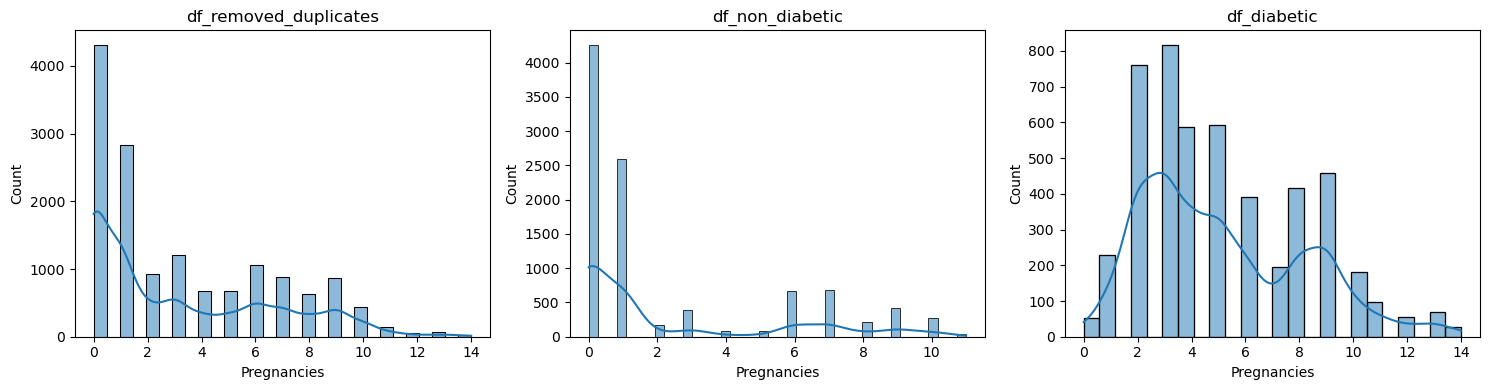

------------------------------
Comparison of data distributions for PlasmaGlucose:
------------------------------


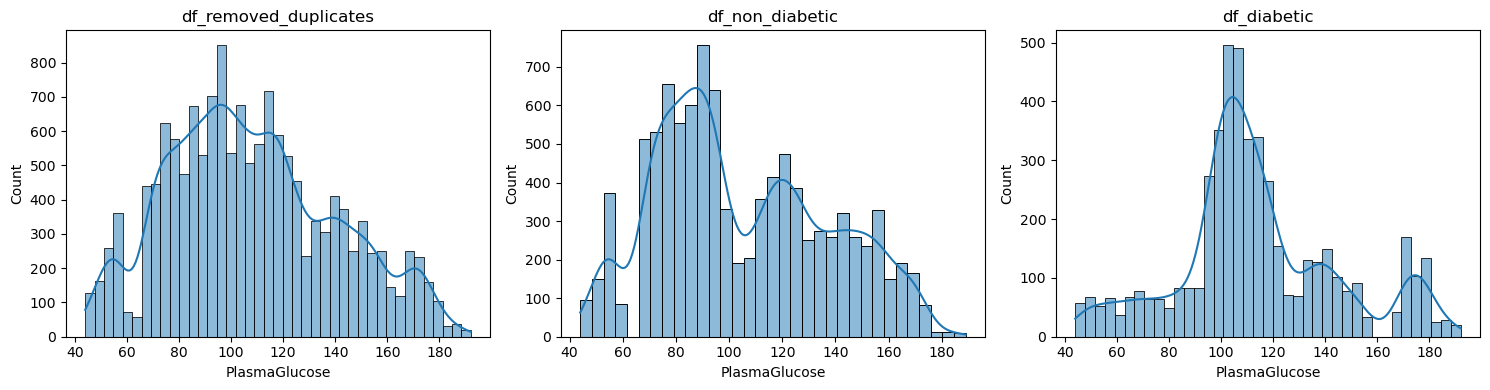

------------------------------
Comparison of data distributions for DiastolicBloodPressure:
------------------------------


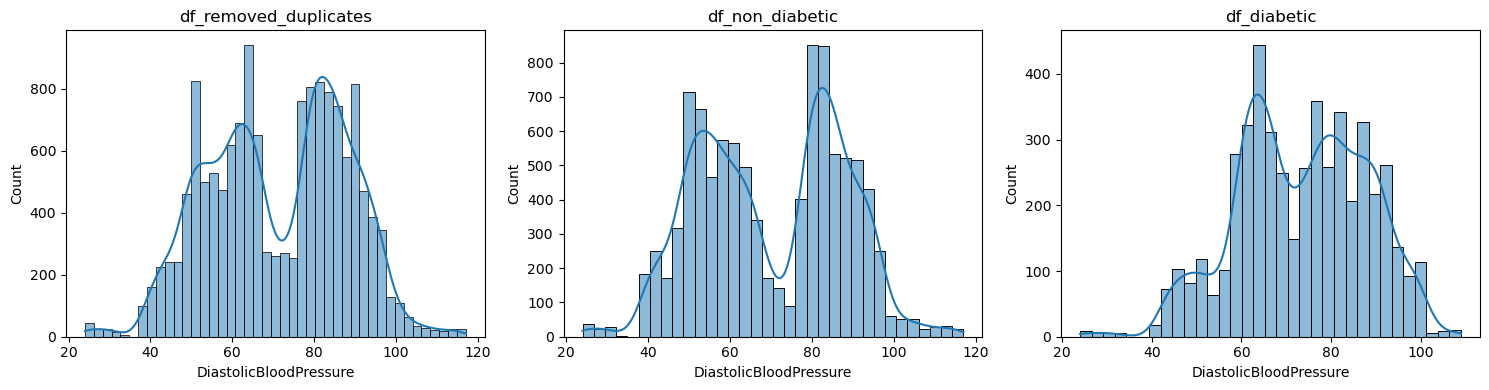

------------------------------
Comparison of data distributions for TricepsThickness:
------------------------------


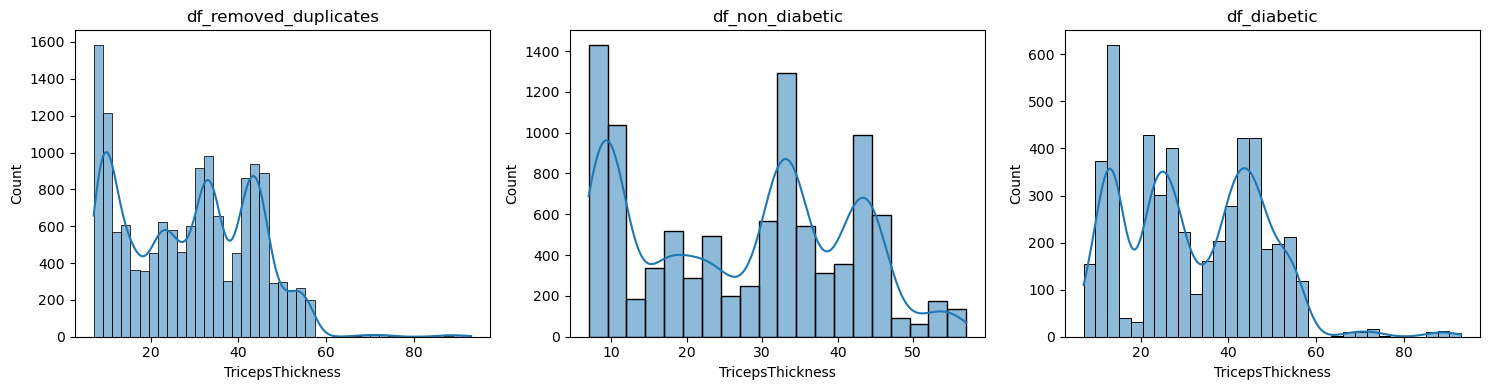

------------------------------
Comparison of data distributions for SerumInsulin:
------------------------------


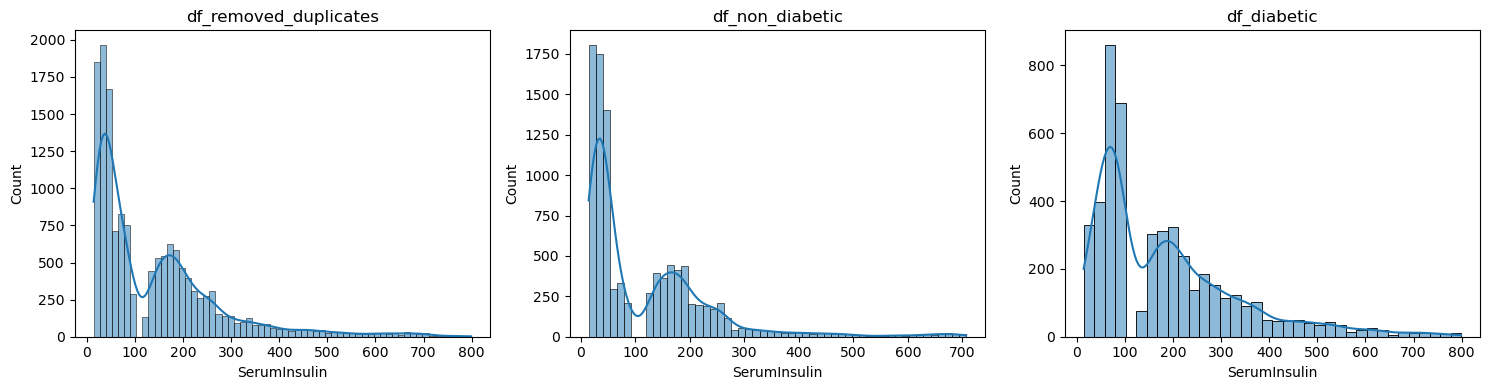

------------------------------
Comparison of data distributions for BMI:
------------------------------


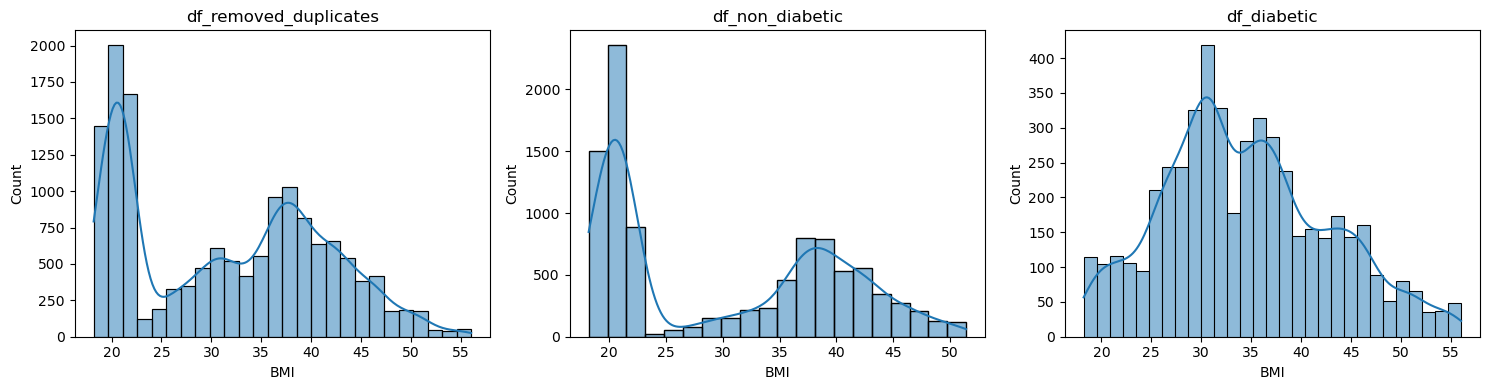

------------------------------
Comparison of data distributions for DiabetesPedigree:
------------------------------


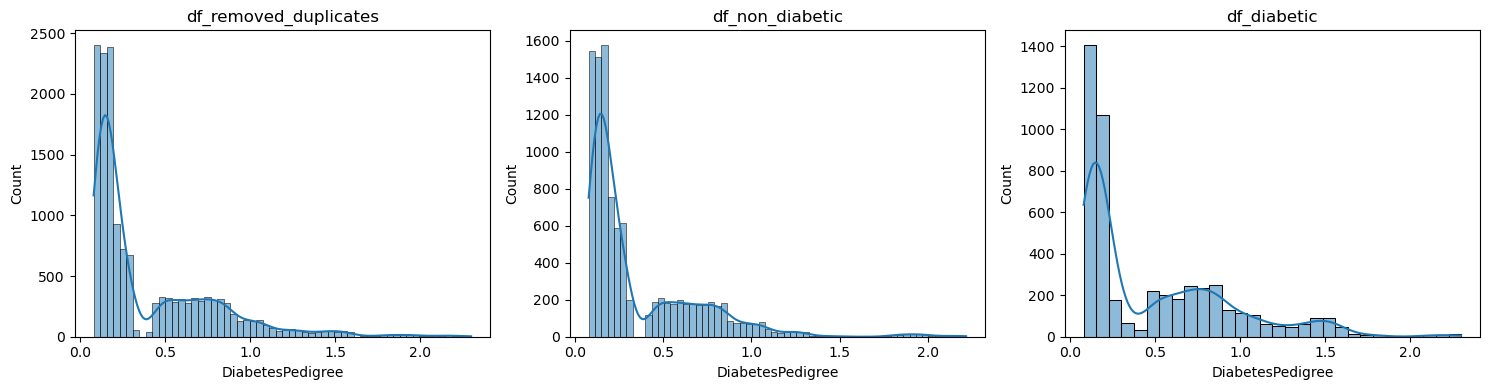

------------------------------
Comparison of data distributions for Age:
------------------------------


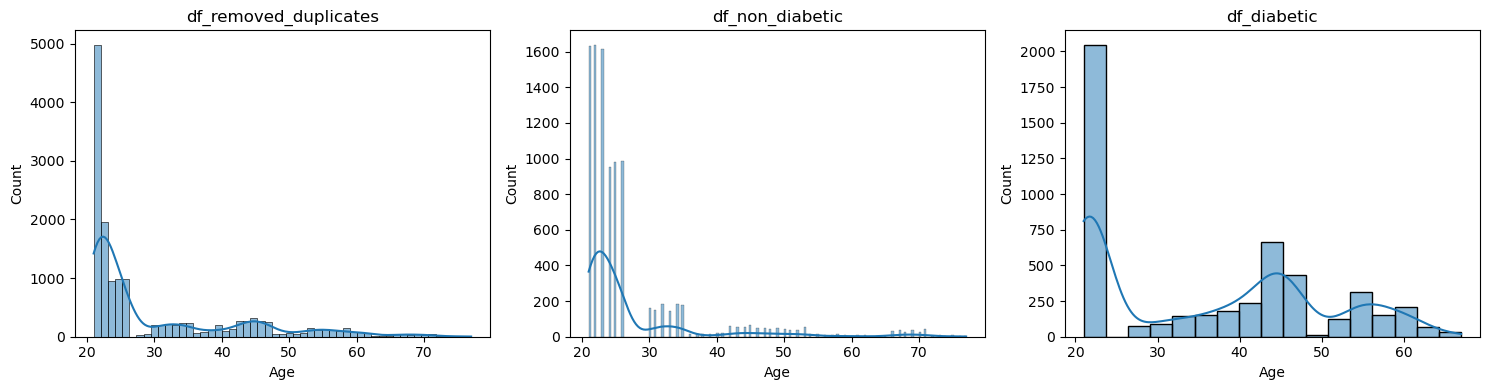

In [33]:
for col in df_removed_duplicates.columns:
    if col != "PatientID" and col!= "Diabetic":
        compare_histograms_per_col([df_removed_duplicates, df_non_diabetic, df_diabetic], ["df_removed_duplicates", "df_non_diabetic", "df_diabetic"], col)

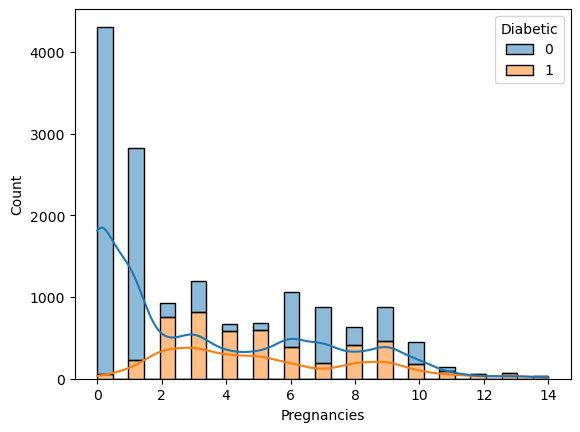

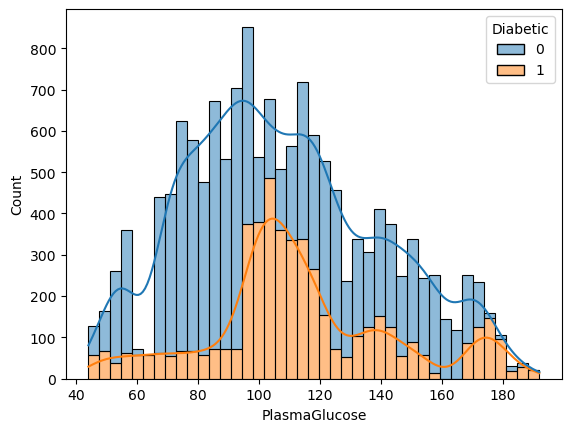

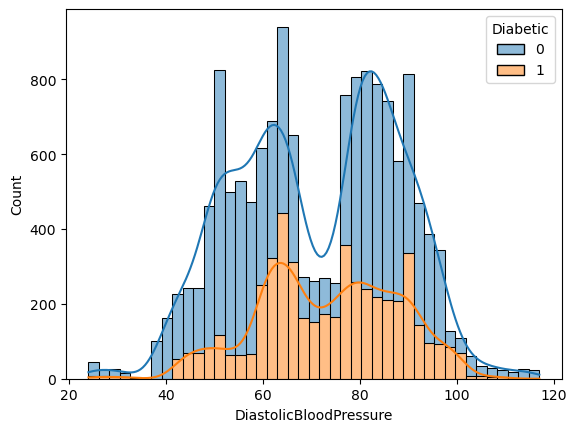

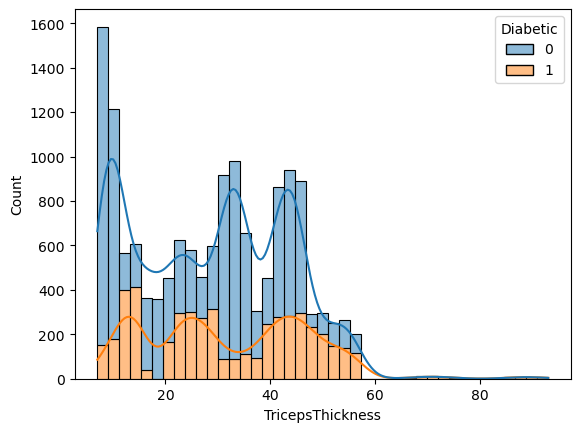

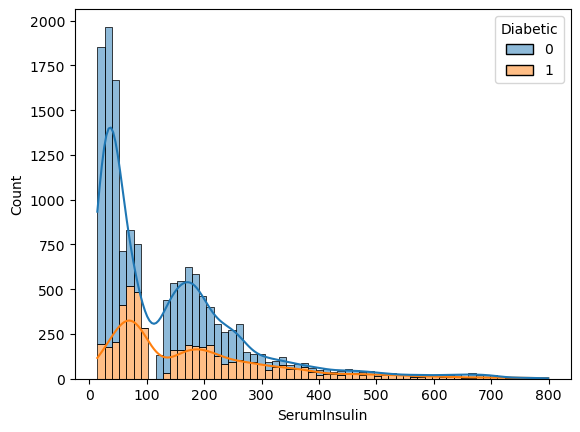

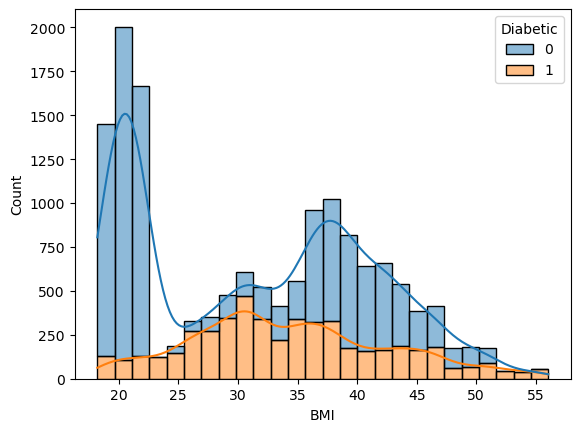

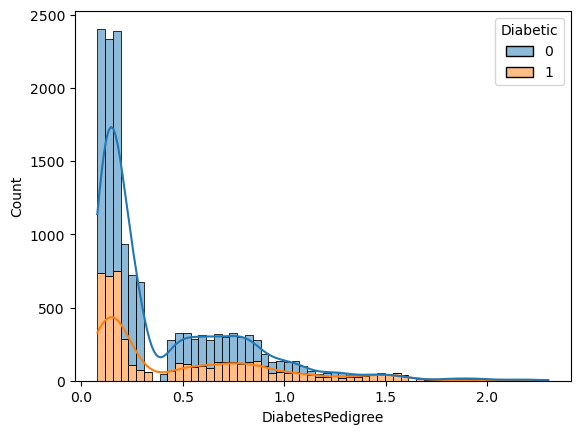

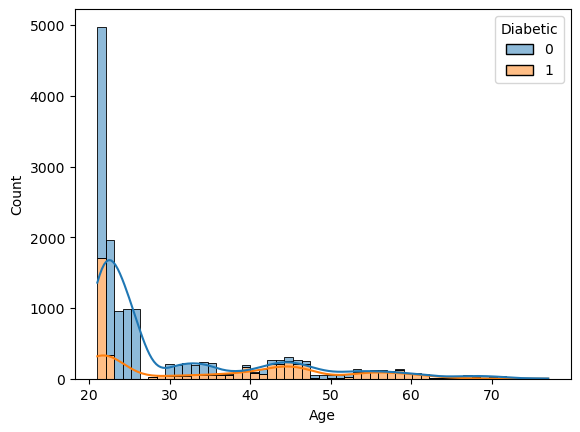

In [34]:
# Comparison of diabetic outcome vs. column
for col_name in df_removed_duplicates.columns:
    if col_name != "PatientID" and col_name!= "Diabetic":
        sns.histplot(data = df_removed_duplicates, x = col_name, hue = "Diabetic", multiple = "stack", kde = True)
    plt.show()

#### **Pregnancies data observations**:

* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have had between 0 and 6 pregnancies, whereas the overall range is 0 to 14 pregnancies;
* diabetic group has a higher average pregnancy count (~5.2 vs. ~2.2 for non-diabetic);
* 50% of all diabetic patient have had ≤ 5 pregnancies (vs. 1 for  non-diabetics), and 75% has had ≤8 pregnancies (vs. 3 for non-diabetics);

#### **Pregnancies data implications**: 
* **Diabetes risk increases as the number of pregnancies grows.**


#### **Plasma Glucose data observations**:
* slightly right-skewed for the full sample and non-diabetic group, roughly symetric for the diabetic group;
* 75% of all patient have a concentration between 44 and 129mg/dL, whereas the overall range is 44 to 192mg/dL;
* diabetic group has a higher average rate (~114mg/dL vs. ~105mg/dL for non-diabetic);
* 50% of all diabetic patient have a concentration of 108mg/dL (vs. 96mg/dL for  non-diabetics), and 75% have 131mg/dL (vs. 128mg/dL for non-diabetics);

#### **Plasma Glucose data implications**: 
* **Diabetic group has a slightly higher Plasma Glucose levels** than non-diabetic group (~105mg/dL vs. ~113.7mg/dL).


#### **Diastolic Blood Pressure data observations**:
* roughly bimodal data distribution across 3 data frames; Might imply that the data came from two different processes or two population group
* 75% of all patient have a diastolic blood pressure between 24 and 85mmHg, equal to the overall range
* diabetic group has a slightly higher average diastolic blood pressure level (~73.4mmHg vs. ~70.1mmHg  for non-diabetic);
* 50% of all diabetic patient has diastolic blood pressure level ≤ 74mmHg (vs. 69mmHg for non-diabetics), and 75% of both diabetic and non-diabetic groups is ≤ 85mmHg;
* 4th quartile (max) trend is reversed, where non-diabetic patients have lower diastolic blood pressure level (109mmHg vs. 117mmHg for non_diabetics).

#### **Diastolic Blood Pressure data implications**: 
* **Higher Diastolic Blood Pressure levels might have a slight impact** on the diabetic outcome.
* **A diastolic blood pressure below 30 is a vital emergency** (cardiac arrest, steptic shock, dehydration, massive blood lost,.. ). Patients with these readings might die without immediate medical intervention. Reading this low raises a suspicion of a data collection error. As consequence, the outliers from of this feature need to be treated.


#### **Triceps Thickness data observations**:
* roughly trimodal data distribution across 3 data frames; Might imply that the data came from three different processes or three population group
* 75% of all patient have a Triceps Skinfold Thickness (TSF) between 7 and 41mm, whereas the overall range is 7 to 93mm;
* diabetic group has a higher average TSF (~32mm vs. ~27mm for non-diabetic);
* 50% of all diabetic patient have a TSF <=29mm (vs. 31mm for  non-diabetics) The median are almost equal, and 75% have <=44mm (vs. 39mm for non-diabetics); 
* 4th quartile (max) for non diabetic is lower than the max for diabetic. In this Data Set, all patient with a TSF > 57mm are diabetic

#### **Triceps Thickness data implications**: 
* **Higher Triceps Skinfold Thickness (TSF) levels might have a huge impact on the diabetic outcome as is describe a diabete predisposition.** A high TSF indicates excess subcutaneous fat, which is often associated with insulin resistance. TSF is a good indirect indicator of insulin sensitivity, especially when it is elevated. However, it must be interpreted in conjunction with other parameters for a more accurate assessment of the risk of diabetes.

#### **Serum Insulin data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Serum Insulin concentration between 14 and 195mu U/ml, whereas the overall range is 14 to 799mu U/ml;
* diabetic group has a higher concentration average (~184mu U/ml vs. ~115mu U/mlfor non-diabetic);
* 50% of all diabetic patient have a Serum Insulin concentration <=153mu U/ml (vs. 52mu U/ml for  non-diabetics), and 75% have <=257mu U/ml (vs. 174mu U/ml for non-diabetics); 
* 4th quartile (max) In this Data Set, all patient with a Serum Insulin concentration > 707mu U/ml are diabetic

#### **Serum Insulin data implications**: 
* **Higher Serum Insulin levels have an impact on the diabetic outcome**
* Serum insulin is an important indicator in the prediction of type 2 diabetes, but it is not sufficient on its own, as it can be normal or low at an advanced stage of diabetes (when the pancreas is exhausted).

#### **BMI data observations**:
* bimodal data distribution across 3 data frames; Might imply that the data came from two different processes or two population group
* 75% of all patient have a Body Mass Index (BMI) between 18Kg/m^2 and 39Kg/m^2, whereas the overall range is 18Kg/m^2 to 56Kg/m^2;
* diabetic group has a higher INDEX average (~34Kg/m^2 vs. ~30Kg/m^2 for non-diabetic);
* 50% of all diabetic patient have an INDEX <=34Kg/m^2 (vs. 28Kg/m^2 for  non-diabetics), and 75% have <=40Kg/m^2 (vs. 39Kg/m^2 for non-diabetics); 

#### **BMI data implications**: 
* **Higher BMI levels might have a direct impact on the diabetic outcome and is an indicator of diabetes predisposition.**

#### **Diabetes Pedigree data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Diabetes Pedigree score between 0.08 and 0.62, whereas the overall range is 0.08 to 2.30;
* diabetic group has a higher score average (~0.49 vs. ~0.35 for non-diabetic);
* 50% of all diabetic patient have an score of <=0.22 (vs. 0.19 for  non-diabetics), and 75% have <=0.77 (vs. 0.52 for non-diabetics); 

#### **Diabetes Pedigree data implications**: 
* **Higher Diabetes Pedigree score might have an impact on the diabetic outcome.**

#### **Age data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient are between 21 and 35 years old, whereas the overall range is 21 to 77;
* diabetic group is older in average (~36 years old vs. ~27 for non-diabetic);
* 50% of all diabetic patients are <=37 (vs. 24 for non-diabetics), and 75% fall <=46 (vs. 26 for non-diabetics); 

#### **Age data implications**: 
* **On average, diabetic patient are older than non-diabetic patients. The risk of diabetes increases as patient get older.**

<Axes: >

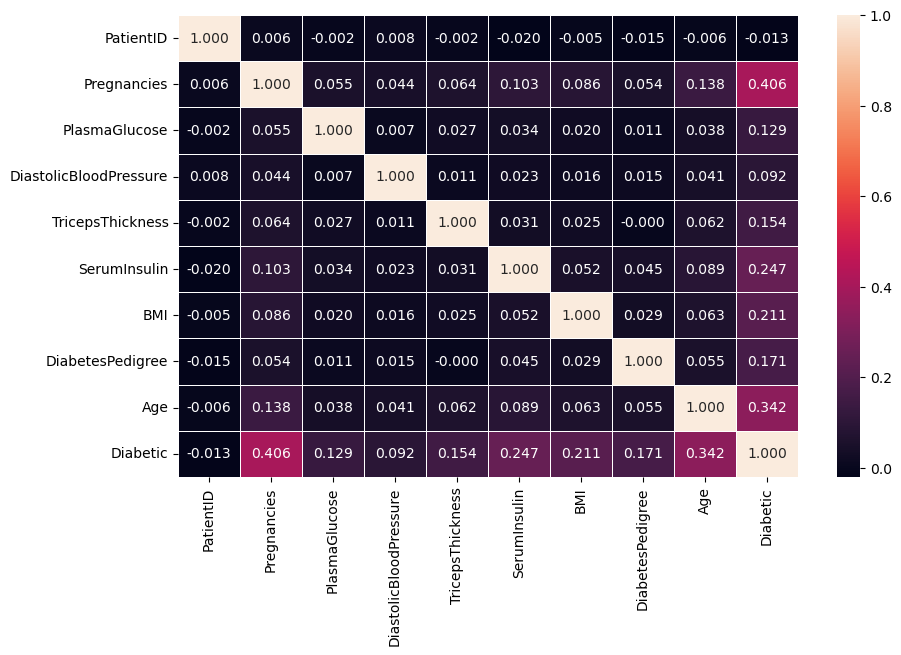

In [35]:
# Heatmap correlation matrix
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_removed_duplicates.corr(), annot=True, fmt=".3f", linewidths=.5, ax=ax)

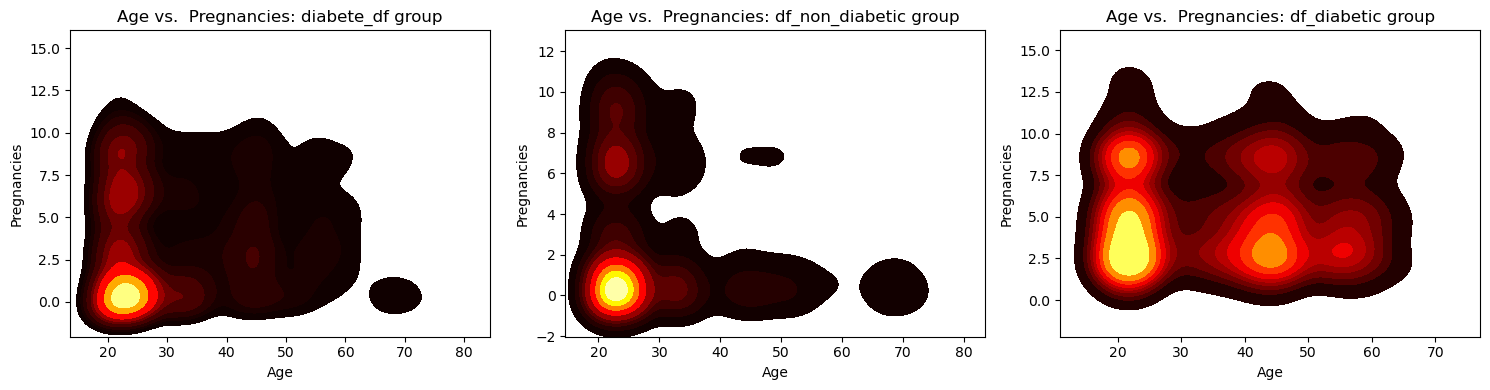

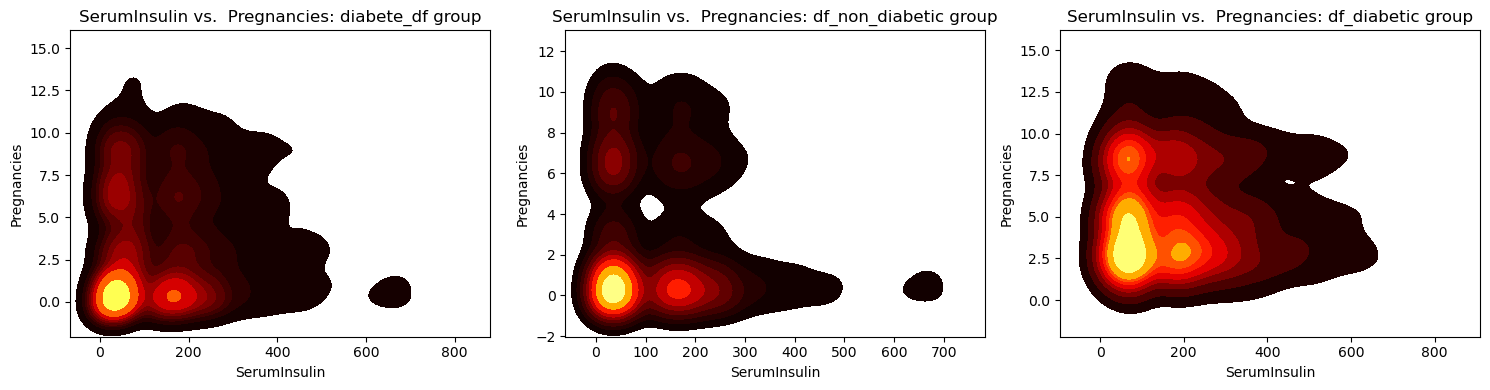

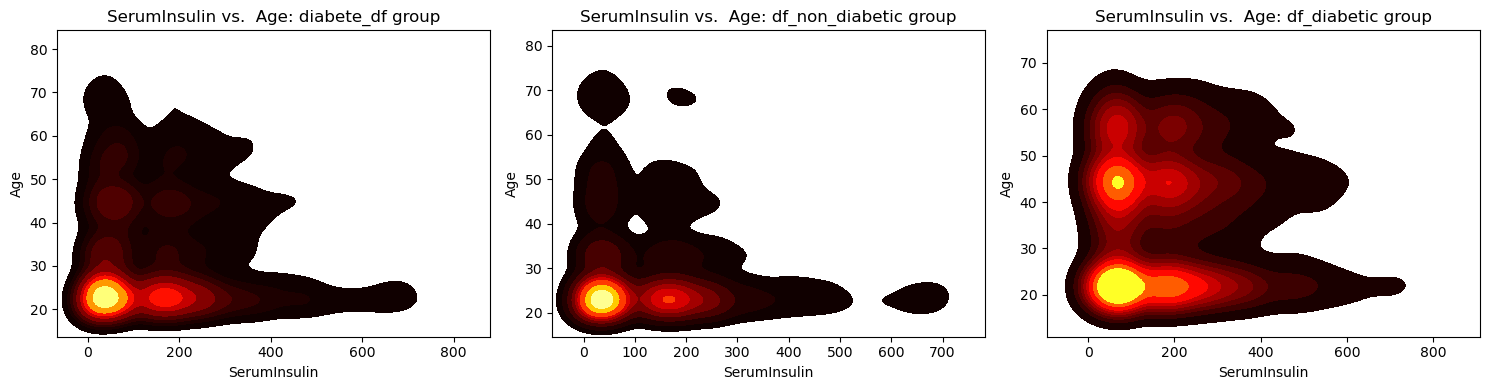

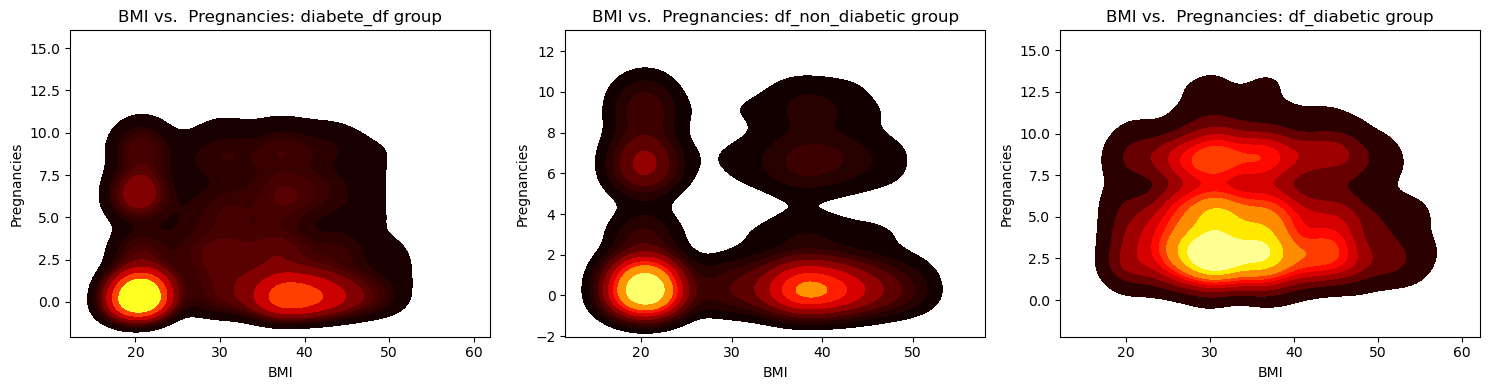

In [ ]:

study_pair = [("Age","Pregnancies"),("SerumInsulin","Pregnancies"),("SerumInsulin","Age"),("BMI","Pregnancies")]
for x,y in study_pair:
    heatmap_per_col([df_removed_duplicates,df_non_diabetic,df_diabetic],["diabete_df","df_non_diabetic","df_diabetic"],x,y)

**Strongest to weakest relationships with the target**: 
* Pregancies (~0.41)
* Age (~0.34)
* Seruminsulin (~0.25)
* BMI (~0.21)
* DiabetesPedigree (~0.17)
* Triceps Thickness (~0.15)
* PlasmaGlucose (~0.13)
* DiastolicBloodPressure (~0.09)

**Other relationships between features with slighly significant correlations**:
* Age vs. Pregnancies (~0.14)
* Pregnancies vs. Serum Insulin (~0.1)
* Age vs. Serum Insulin (~0.09)
* Pregnancies vs. BMI (~0.09)

**Additional notes:**
* The positive correlation hints to us that the above present features have a positive relationship to our target (Diabetic), meaning that as they increase, the possibility of having a diabetes increases as well.
* Pregnancies (~0.41), age (~0.34) and seum insulin (~0.25) are top 3 features that have the strongest correlation with the diabetes status therefore they might be strong predictors of the diabetic outcome.
* Triceps thickness, plasma glucose and diastolic blood pressure having rather weak positive correlation light still contribute to the prediction of the diabetic outcome, but are not individually strong predictors in the given dataset.

---
## **3.3 Outliers detection**

**This part is dedicated to:**
* Detect the presence of potential outliers;
* Decide on how to treat the outliers present in the dataset.

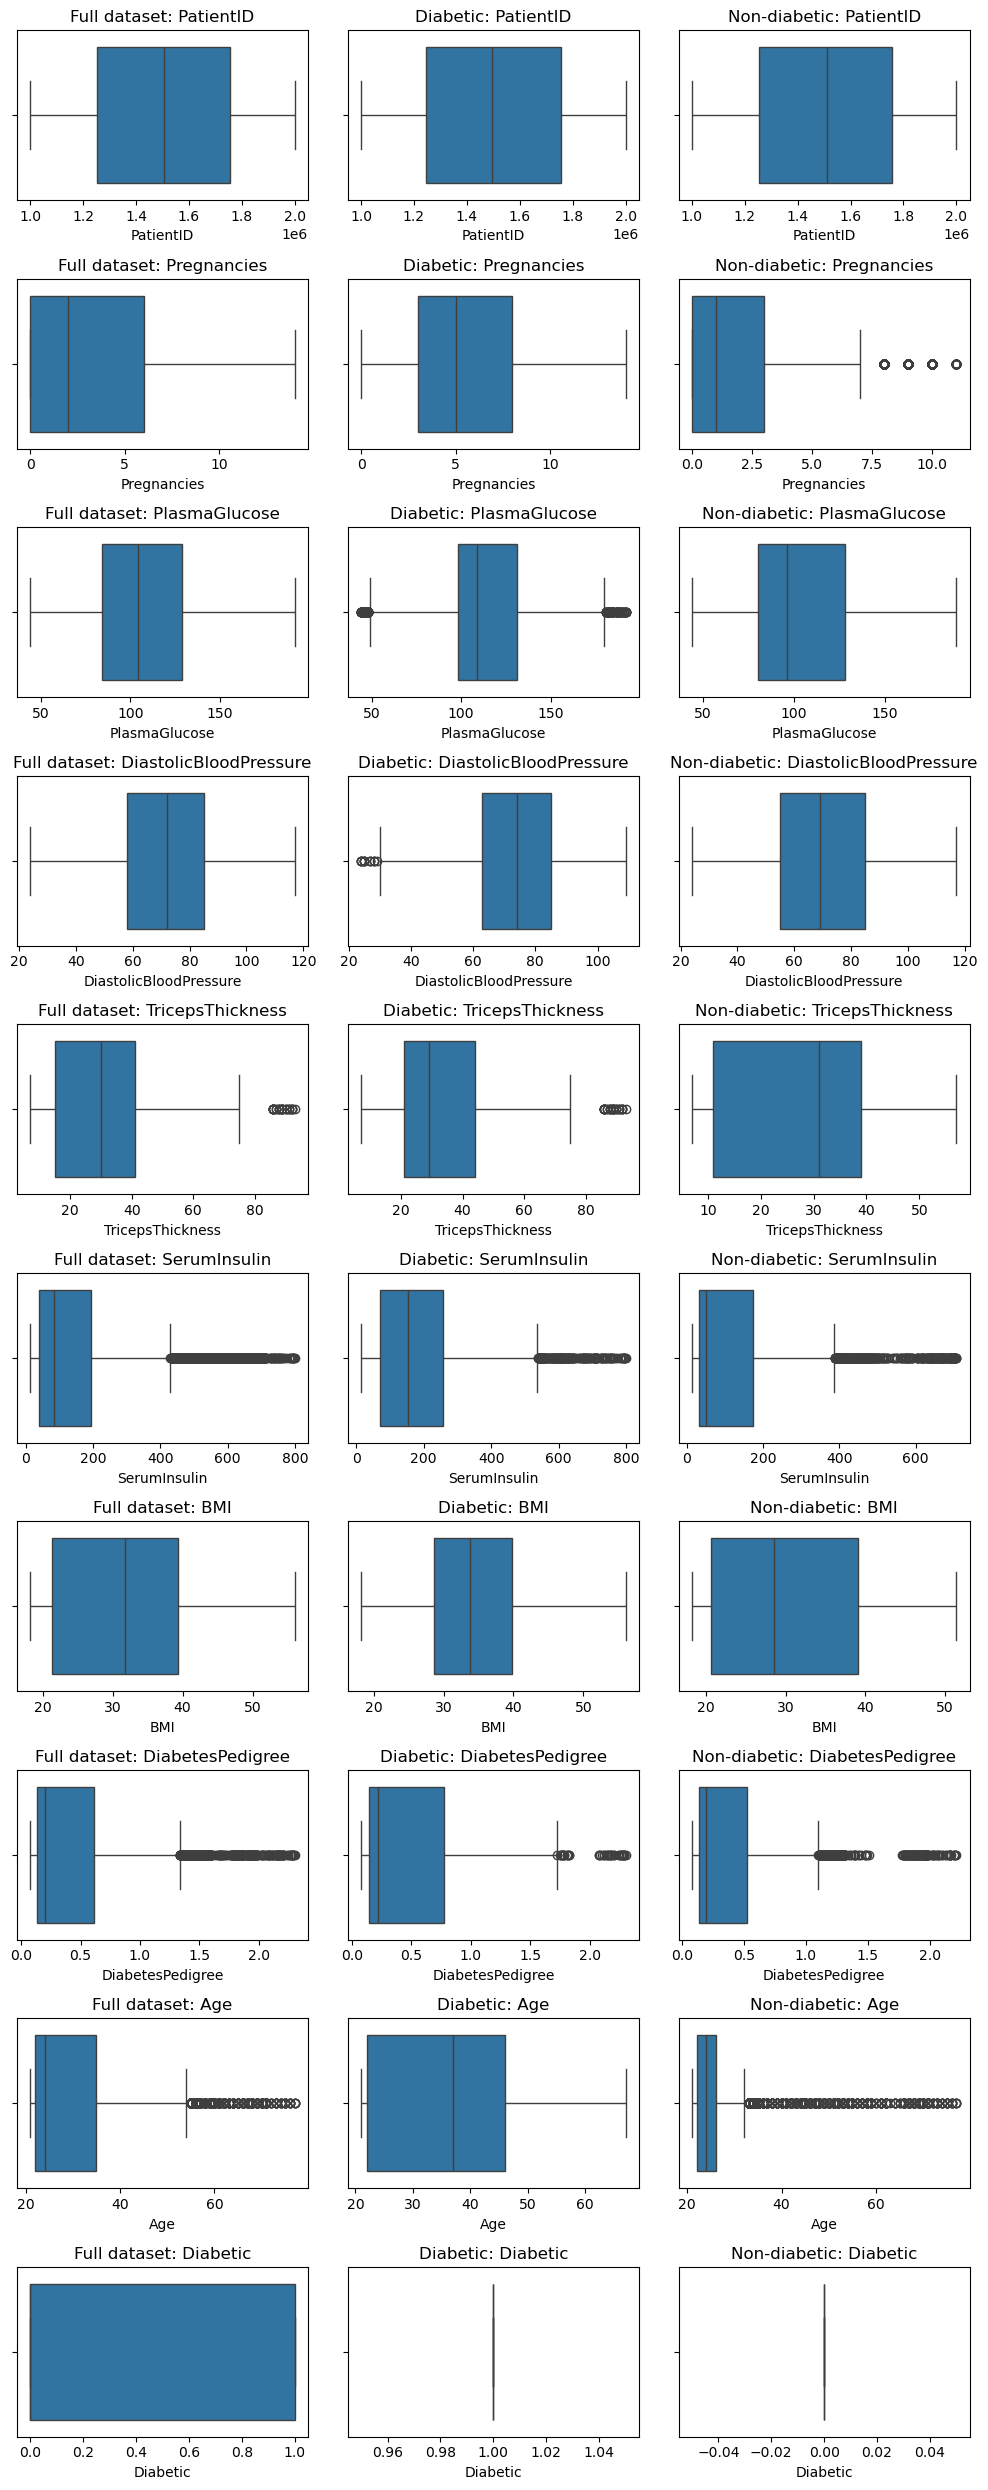

In [16]:
columns = df_removed_duplicates.columns
nb_rows = len(columns)

fig, axes = plt.subplots(ncols = 3, nrows = nb_rows, figsize = (10, 25))

for i, col in enumerate(columns):
        sns.boxplot(data = df_removed_duplicates, x = col, ax = axes[i, 0])
        axes[i, 0].set_title(f"Full dataset: {col}")
        
        sns.boxplot(data = df_diabetic, x = col, ax=axes[i, 1])
        axes[i, 1].set_title(f"Diabetic: {col}")
        
        sns.boxplot(data = df_non_diabetic, x = col, ax = axes[i, 2])
        axes[i, 2].set_title(f"Non-diabetic: {col}")

plt.tight_layout()
plt.show()

In [37]:
count_outliers(df_removed_duplicates, "Age", "DiabetesPedigree", "TricepsThickness", "SerumInsulin")

,Column,Outlier count,Lower bound,Upper bound
0,Age,1008,2.500000,54.500000
1,DiabetesPedigree,471,-0.579927,1.333455
2,TricepsThickness,31,-24.000000,80.000000
3,SerumInsulin,658,-195.000000,429.000000


In [38]:
# Split of the outliers for Age according to the diabetic outcome
age_outliers_df = df_removed_duplicates[(df_removed_duplicates['Age'] > 54.5) | (df_removed_duplicates['Age'] < 2.5)]
age_outliers = age_outliers_df.groupby('Diabetic')['Age'].count()

print(age_outliers)

Diabetic
0    329
1    679
Name: Age, dtype: int64


In [39]:
# Split of the outliers for Diabetes Pedigree according to the diabetic outcome
diabetes_predigee_outliers_df = df_removed_duplicates[(df_removed_duplicates['DiabetesPedigree'] > 1.333455) | (df_removed_duplicates['DiabetesPedigree'] < -0.579927)]
diabetes_predigee_outliers = diabetes_predigee_outliers_df.groupby('Diabetic')['DiabetesPedigree'].count()

print(diabetes_predigee_outliers)

Diabetic
0    124
1    347
Name: DiabetesPedigree, dtype: int64


In [40]:
# Split of the outliers for Serum Insulin according to the diabetic outcome
serum_insulin_outliers_df = df_removed_duplicates[(df_removed_duplicates['SerumInsulin'] > 429) | (df_removed_duplicates['SerumInsulin'] < -195)]
serum_insulin_outliers = serum_insulin_outliers_df.groupby('Diabetic')['SerumInsulin'].count()

print(serum_insulin_outliers)

Diabetic
0    263
1    395
Name: SerumInsulin, dtype: int64


In [41]:
# Split of the outliers for Triceps Thickness according to the diabetic outcome
triceps_thickness_outliers_df = df_removed_duplicates[(df_removed_duplicates['TricepsThickness'] > 80) | (df_removed_duplicates['TricepsThickness'] < -24)]
triceps_thickness_outliers = triceps_thickness_outliers_df.groupby('Diabetic')['TricepsThickness'].count()

print(triceps_thickness_outliers)

Diabetic
1    31
Name: TricepsThickness, dtype: int64


#### **Outliers detection observations**:
* Presence of many outliers according to the above statistics.
* Outliers present in the dataset might be meaningful and provide insights into less-frequent cases, an not forcefully be erronous data.
* Some of the pre-selected models (ex. KNN, logistic regression) can be heavily impacted by the presence of the outliers.

#### **Outliers detection implications**:
* Large number of outliers excludes the direct removal approach, since it would imply a significant size change of the dataset.
* Presence of the extreme values might be a result of real, extreme cases, where these outliers are meaningful. Based on the data observations, we have decided to limit the extreme values for Triceps Thickness, Serum Insulin and Diabetes Pedigree by transforming them using the winsorization technique with the common tresholds of top and bottom 5% in order to reduce the data noise, as well as impove the stability of performance metrics.

---
# **4. FEATURE ENGINEERING & DATA PREPROCESSING**
---

## **4.1 PIMA indian dataset preparation for cross-validation**

**This part is dedicated to:**
* have a look at the PIMA indian dataset;
* sanitize the data if necessary. 

In [74]:
# Original df import
pima_indian_dataset = pd.read_csv(r"../Notebooks/pima_indian_dataset.csv")

# Creation of a deep copy of the PIMA Indian Dataset
pima_indian_dataset_raw = pima_indian_dataset.copy()

In [75]:
# Quick look at the dataset
pima_indian_dataset.info()
pima_indian_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [76]:
# Columns name change
pima_indian_dataset = pima_indian_dataset.rename(columns=
{"Glucose": "PlasmaGlucose",
"BloodPressure": "DiastolicBloodPressure",
"SkinThickness": "TricepsThickness",
"Insulin": "SerumInsulin",
"DiabetesPedigreeFunction": "DiabetesPedigree",
"Outcome":"Diabetic"})

pima_indian_dataset.describe()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Many zero values present in the dataset. Since it is a real world data, concerning a sensitive subject of health, as well as cross-validation dataset in additional to the regular training set, we will tweak it only on using minimal changes: 
* change the column names to correspond to those in the training dataset;
* drop the rows with 0 values in the columns, with the exception of pregnancies number and diabetic outcome, to focus only on patients that underwent a full medical check-up.

In [69]:
# Dropping the rows with 0 values present across the features
cols_to_check = pima_indian_dataset.columns.drop(['Diabetic', 'Pregnancies'])
pima_trimmed = pima_indian_dataset[(pima_indian_dataset[cols_to_check] != 0).all(axis=1)]
pima_trimmed.describe()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [77]:
# Check of the data changes after the 0 values drop
pima_trimmed.info()
pima_trimmed.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 3 to 765
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Pregnancies             392 non-null    int64  
 1   PlasmaGlucose           392 non-null    int64  
 2   DiastolicBloodPressure  392 non-null    int64  
 3   TricepsThickness        392 non-null    int64  
 4   SerumInsulin            392 non-null    int64  
 5   BMI                     392 non-null    float64
 6   DiabetesPedigree        392 non-null    float64
 7   Age                     392 non-null    int64  
 8   Diabetic                392 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 30.6 KB


,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


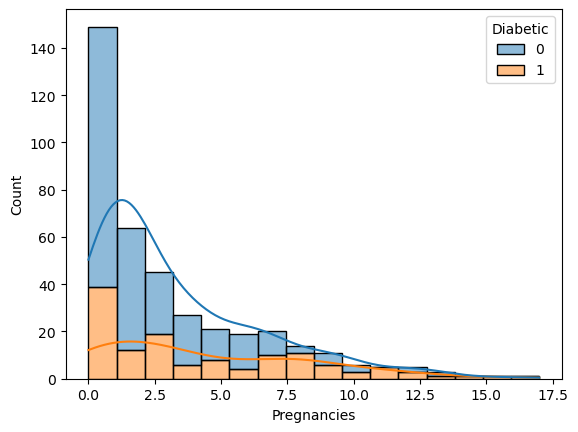

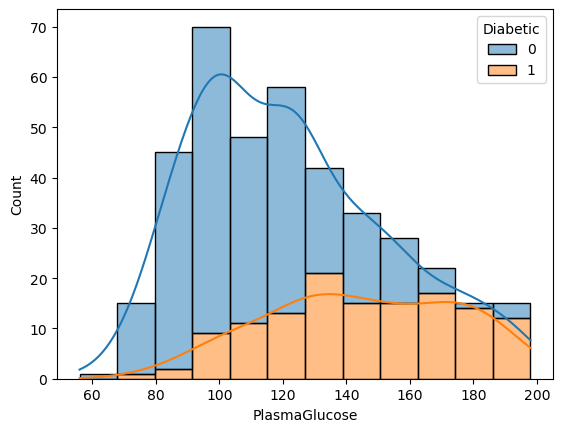

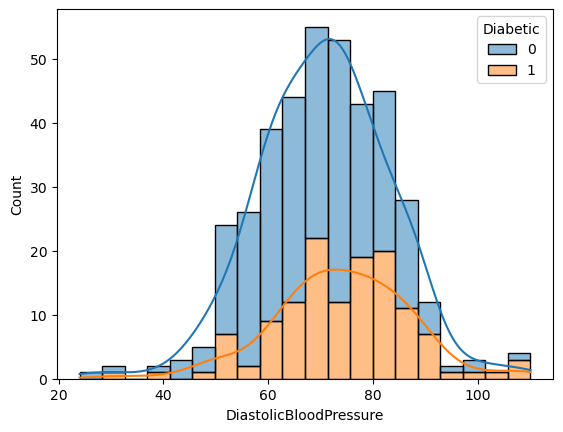

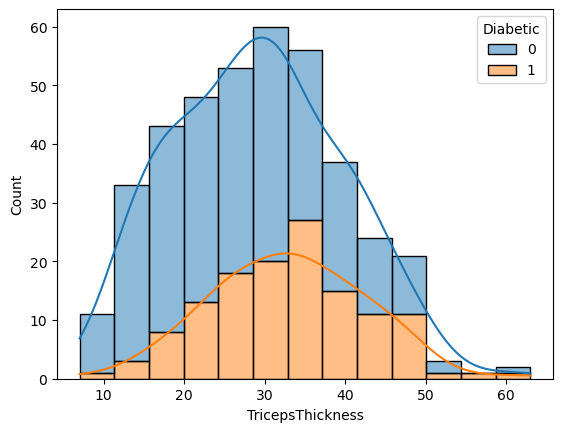

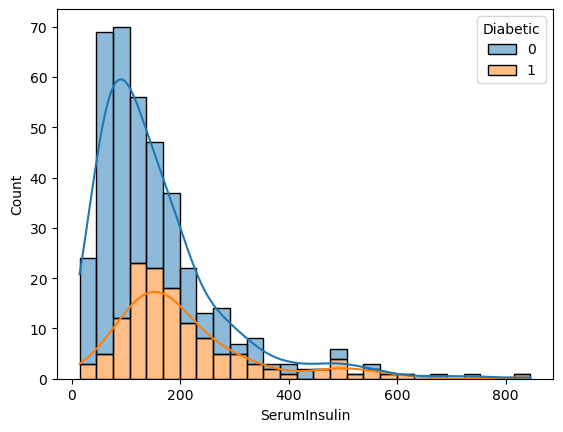

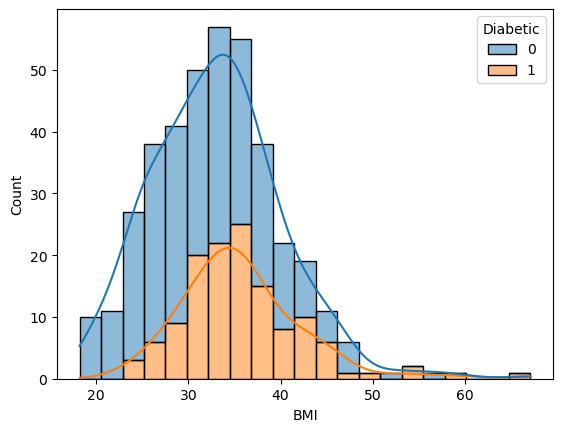

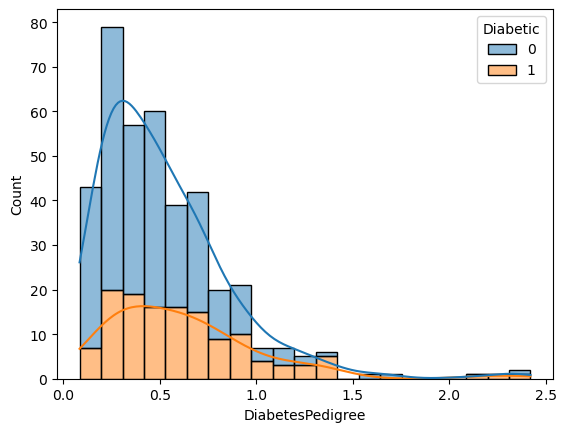

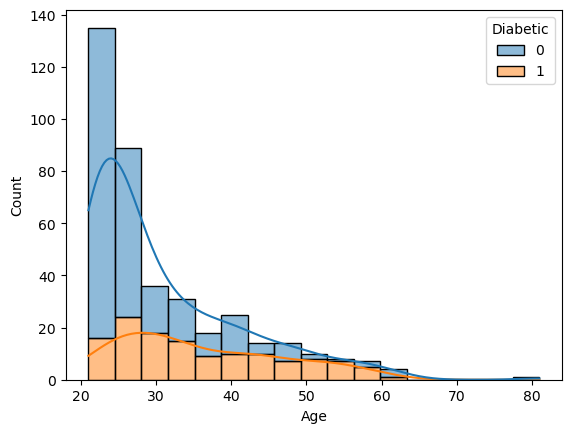

In [ ]:
# Verification of the data distributions for the trimmed pima dataset
for col_name in pima_trimmed.columns:
    if col_name != "PatientID" and col_name!= "Diabetic":
        sns.histplot(data = pima_trimmed, x = col_name, hue = "Diabetic", multiple = "stack", kde = True)
    plt.show()

Dropping zero values reduces the dataset size by nearly half, but this is not a concern. This dataset is only used for cross-checking an extra indicator, not for the main performance metrics. Removing zeros makes the data more realistic and helps prevent the model from getting confused during validation. It’s a simple trade-off that leads to more reliable results.

---
## **4.2 Outliers transformation**

**This part is dedicated to:**
* limit the influence of the outliers on the models by capping them for triceps thickness, serul insulin and diabetes pedigree.

## **4.2 Outliers transformation**

**This part is dedicated to:**
* limit the influence of the outliers on the models by capping the outliers for triceps thickness, serul insulin and diabetes pedigree.

In [42]:
# Creation of a deep copy of the dataset before applying the transformations
df_with_outliers_p1 = df_removed_duplicates.copy()
df_without_outliers_p2 = df_removed_duplicates.copy()

In [78]:
# Winsorization of the outliers
df_winsorized = df_removed_duplicates.copy()

for col in df_winsorized.columns:
    if col in ["TricepsThickness", "SerumInsulin", "DiabetesPedigree"]:
        df_winsorized[col] = winsorize(df_winsorized[col], limits=(0.05, 0.05))

df_winsorized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14790 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               14790 non-null  int64  
 1   Pregnancies             14790 non-null  int64  
 2   PlasmaGlucose           14790 non-null  int64  
 3   DiastolicBloodPressure  14790 non-null  int64  
 4   TricepsThickness        14790 non-null  int64  
 5   SerumInsulin            14790 non-null  int64  
 6   BMI                     14790 non-null  float64
 7   DiabetesPedigree        14790 non-null  float64
 8   Age                     14790 non-null  int64  
 9   Diabetic                14790 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.2 MB


<Figure size 640x480 with 0 Axes>

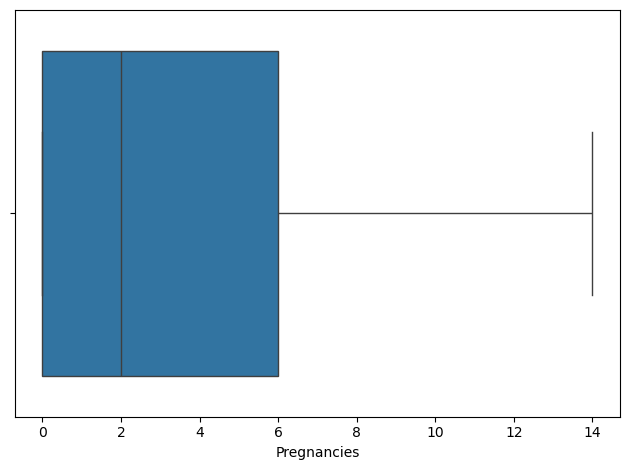

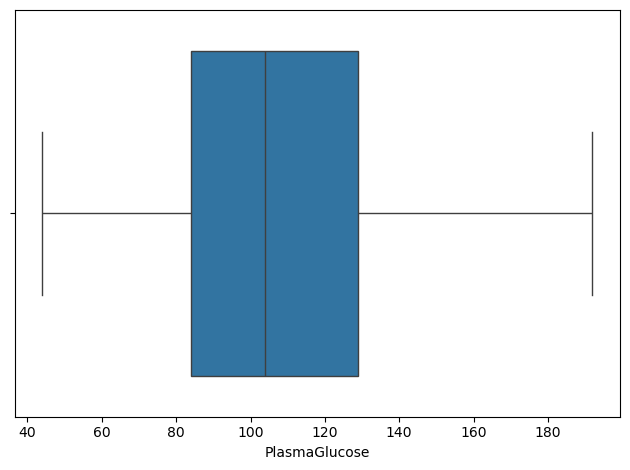

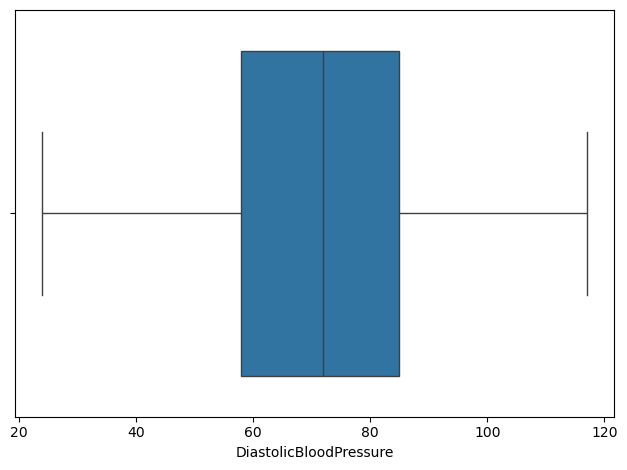

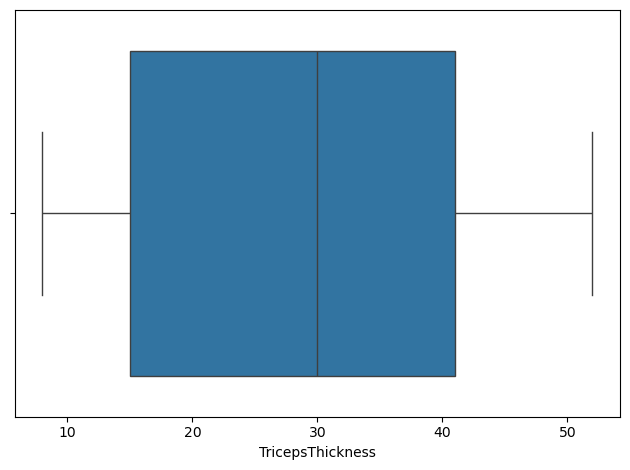

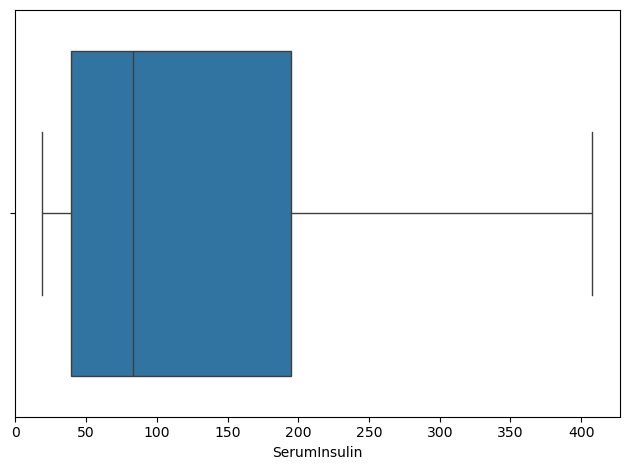

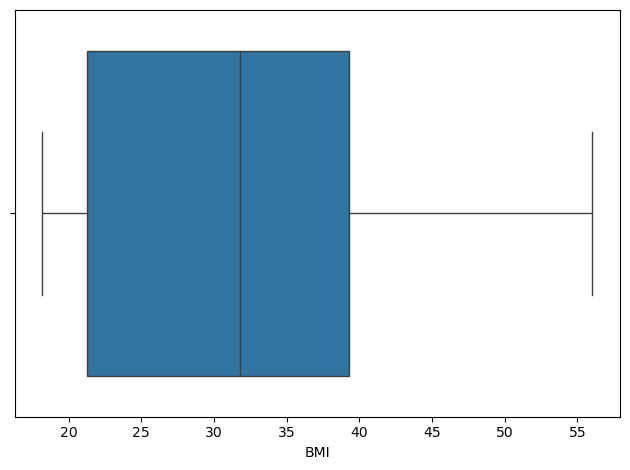

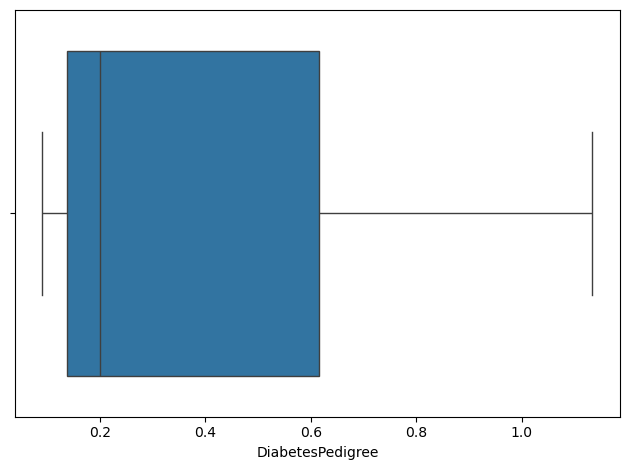

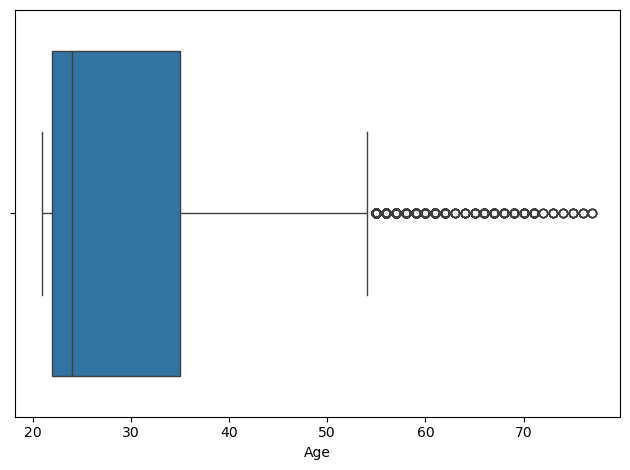

<Figure size 640x480 with 0 Axes>

In [44]:
for col in df_winsorized.columns:
    if col not in ["PatientID", "Diabetic"]:
        sns.boxplot(data = df_winsorized, x = col)
    plt.tight_layout()
    plt.show()

---
## **4.3 Additional features engineering**

**This part is dedicated to:**
* 



* Idea 1 : Bin the patients into categories based on BMI : bmi_classification (for women) - https://pmc.ncbi.nlm.nih.gov/articles/PMC8306797/ + encode the values using 
    * < 18.5 - underweight
    * <= 15.5 < 24 - normal weight
    * <= 24 < 27 overweight
    * <= 27 < 35 - obese
    * >= 35 - severe obesity

* Idea 2 : 

---
# **5. MODELS TRAINING & EVALUATION**
---

## **5.0 Preparation of the base case for the machine learning models & iterative improvement**

**This part is dedicated to:**
* splitting the datasets into trainig and test sets
* preparation of performance metrics for evaluation purposes

In [174]:
# Split of the winsorized dataset into train and test dataset ; stratification to address the initial imbalances of the distribution of the target classes
X = df_winsorized.drop(columns=["PatientID", "Diabetic"])
y = df_winsorized["Diabetic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)


# Split of the pima indian dataset into cross-validation test dataset
X_pima = pima_trimmed.drop(columns=["Diabetic"])
y_pima = pima_trimmed["Diabetic"]

In [ ]:
# DATASETS DO NOT EXIST YET
# Split of the engineered dataset into train and test dataset ; stratification to address the initial imbalances of the distribution of the target classes
"""
X_engineered = df_engineered.drop(columns=["PatientID", "Diabetic"])
y_engineered = df_engineered["Diabetic"]
X_engineered_train, X_engineered_test, y_engineered_train, y_engineered_test = train_test_split(X_engineered, y_engineered, test_size = 0.2, random_state = 0, stratify = y_engineered)

# Split of the engineered pima indian dataset into cross-validation test dataset

X_pima_engineered = pima_engineered.drop(columns=["Diabetic"])
y_pima_engineered = pima_engineered["Diabetic"]
"""

## **5.1 Pipeline 1: Logistic Regression model**


Improvement strategy:
1. Treatment of the data skeweness with yeo-johnson transformation
2. RobustScaler
3. Try only SMOTE
4. Try only Tomek Links
5. Try SMOTE & Tomk Links together
6. Hyperparameter tuning

In [200]:
# Logistic Regression training
lr_v0 = LogisticRegression(random_state = 0, max_iter = 1000)
lr_v0.fit(X_train, y_train)

# Logistic Regression test data prediction
lr_v0_test_prediction = lr_v0.predict(X_test)

# Logistic Regression cross validation using pima indian dataset
lr_v0_pima_prediction = lr_v0.predict(X_pima)

# Logistic Regression performance metrics
model_performance_metrics(y_test, lr_v0_test_prediction, y_pima, lr_v0_pima_prediction)

Test data results:
------------------------------
Classification Report - test dataset:
------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1972
           1       0.72      0.59      0.65       986

    accuracy                           0.78      2958
   macro avg       0.76      0.74      0.75      2958
weighted avg       0.78      0.78      0.78      2958



------------------------------
Confusion Matrix - test dataset:
------------------------------
[[1742  230]
 [ 406  580]]


------------------------------
AUC-ROC score - test dataset:
------------------------------
0.7358012170385396


Cross-validation with the PIMA Indian dataset results:
------------------------------
Classification Report - PIMA Indian dataset:
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       262
           1       0.61      0.66      0.63 

## **5.2 Pipeline 2: K-Nearest Neighbors model**

Improvement strategy:
1. Treatment of the data skeweness with yeo-johnson transformation
2. RobustScaler
3. Try only SMOTE
4. Try only Tomek Links
5. Try SMOTE & Tomk Links together
6. Hyperparameter tuning

In [201]:
# K-Nearest Neighbors training
knn_v0 = KNeighborsClassifier()
knn_v0.fit(X_train, y_train)

# K-Nearest Neighbors test data prediction
knn_v0_test_prediction = knn_v0.predict(X_test)

# K-Nearest Neighbors cross-validation using pima indian dataset
knn_v0_pima_prediction = knn_v0.predict(X_pima)

# K-Nearest Neighbors performance metrics
model_performance_metrics(y_test, knn_v0_test_prediction, y_pima, knn_v0_pima_prediction)

Test data results:
------------------------------
Classification Report - test dataset:
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1972
           1       0.79      0.74      0.76       986

    accuracy                           0.85      2958
   macro avg       0.83      0.82      0.83      2958
weighted avg       0.85      0.85      0.85      2958



------------------------------
Confusion Matrix - test dataset:
------------------------------
[[1781  191]
 [ 258  728]]


------------------------------
AUC-ROC score - test dataset:
------------------------------
0.8207403651115619


Cross-validation with the PIMA Indian dataset results:
------------------------------
Classification Report - PIMA Indian dataset:
------------------------------
              precision    recall  f1-score   support

           0       0.70      0.55      0.62       262
           1       0.37      0.52      0.43 

KNN Iteration 1 : Hyperparameters tuning

In [164]:
# K-Nearest Neighbors training
knn_v1 = KNeighborsClassifier(weights = "distance", metric = "manhattan")
knn_v1.fit(X_train, y_train)

# K-Nearest Neighbors test data prediction
knn_v1_test_prediction = knn_v1.predict(X_test)

# K-Nearest Neighbors cross validation using pima indian dataset
knn_v1_pima_prediction = knn_v1.predict(X_pima)

## **5.3 Pipeline 3: Random Forest model**

Improvement strategy:
1. Try only SMOTE
2. Try only Tomek Links
3. Try SMOTE & Tomk Links together
4. Hyperparameter tuning

In [89]:
# Random Forest training
rf_v0 = RandomForestClassifier(random_state = 0)
rf_v0.fit(X_train, y_train)

# Random Forest test data prediction
rf_v0_test_prediction = rf_v0.predict(X_test)

# Random Forest cross validation using pima indian dataset
rf_v0_pima_prediction = rf_v0.predict(X_pima)

Iteration 1 : Over-sampling the data using

## **5.4 Pipeline 4: XGBoost model**

Improvement strategy:
1. Try only SMOTE
2. Try only Tomek Links
3. Try SMOTE & Tomk Links together
4. Hyperparameter tuning